# Introduction

A lot of code in this notebook is taken from [https://www.kaggle.com/code/mariushinsberger/xgboost-on-obesity-risk](http://) notebook. Thank you, Marius, for sharing your work and getting beginners like myself excited about XGradientBoosting. Keep up the great work! 

**Approaching the problem:**
1. EDA 
2. Preprocessing of the Data 
3. Parameter Tuning
4. Applying the XGBoost Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2

# Get Data

In [3]:
path = str("/kaggle/input/playground-series-s4e2")
train = pd.read_csv(f"{path}/train.csv")
test = pd.read_csv(f"{path}/test.csv")
submission = pd.read_csv(f"{path}/sample_submission.csv")

# EDA 
To build a multi-class classifier to predict obesity risk in individuals, which is related to cardiovascular disease. Here is the plan:
* Applying data pre-processing steps
* trying different baseline algorithms
* optimizing the hyperparameters of XGBoost

In [4]:
print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Training data shape: (20758, 18)
Test data shape: (13840, 17)


In [5]:
train.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,20758.000000,10378.500000,5992.462780,0.000000,5189.250000,10378.500000,15567.750000,20757.000000
Age,20758.000000,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.000000,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.000000,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.000000,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.000000,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.000000,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.000000,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.000000,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000


In [6]:
test.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,13840.000000,27677.500000,3995.408198,20758.000000,24217.750000,27677.500000,31137.250000,34597.000000
Age,13840.000000,23.952740,5.799814,14.000000,20.000000,22.906342,26.000000,61.000000
Height,13840.000000,1.698934,0.088761,1.450000,1.631662,1.700000,1.760710,1.980000
Weight,13840.000000,87.384504,26.111819,39.000000,65.000000,83.952968,111.157811,165.057269
FCVC,13840.000000,2.442898,0.531606,1.000000,2.000000,2.358087,3.000000,3.000000
NCP,13840.000000,2.750610,0.710927,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,13840.000000,2.032044,0.611230,1.000000,1.771781,2.000000,2.552388,3.000000
FAF,13840.000000,0.974532,0.840361,0.000000,0.001086,1.000000,1.571865,3.000000
TUE,13840.000000,0.611033,0.608005,0.000000,0.000000,0.552498,1.000000,2.000000


Defining the continuous and categorical variables.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

**Target Analysis**

Target selection: 

In [8]:
target = train["NObeyesdad"]
train.drop(columns=["id", "NObeyesdad"], inplace=True)
test_id = test["id"]
test.drop(columns=["id"], inplace=True)

This shows us the different values which our target can take on.

In [9]:
target.value_counts(ascending=False)

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

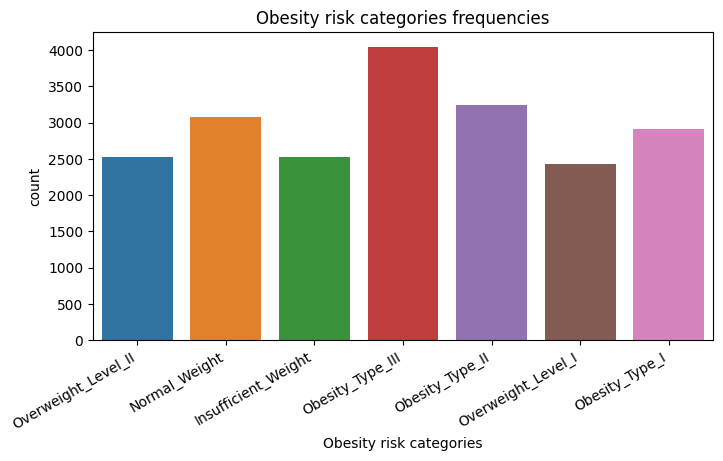

In [10]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x=target)
plt.title("Obesity risk categories frequencies")
plt.xlabel("Obesity risk categories")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")
plt.show()

## Feature Analysis

I will be using the filter-based feature selection approach, and to select my features:
* EDA on features
* Feature engineering 


In [11]:
categorical_features = train.select_dtypes(include=["object"]).columns
numerical_features = train.select_dtypes(include=["int64", "float64"]).columns

for feature in categorical_features:
    print(f"{feature}: {train[feature].unique()}")
    if feature == "NObeyesdad": continue
    print(f"{feature}: {test[feature].unique()}")   

Gender: ['Male' 'Female']
Gender: ['Male' 'Female']
family_history_with_overweight: ['yes' 'no']
family_history_with_overweight: ['yes' 'no']
FAVC: ['yes' 'no']
FAVC: ['yes' 'no']
CAEC: ['Sometimes' 'Frequently' 'no' 'Always']
CAEC: ['Sometimes' 'Always' 'Frequently' 'no']
SMOKE: ['no' 'yes']
SMOKE: ['no' 'yes']
SCC: ['no' 'yes']
SCC: ['no' 'yes']
CALC: ['Sometimes' 'no' 'Frequently']
CALC: ['Sometimes' 'no' 'Frequently' 'Always']
MTRANS: ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
MTRANS: ['Public_Transportation' 'Automobile' 'Walking' 'Bike' 'Motorbike']


In [12]:
feature_dict = {
    "Gender": {
        'Female': 0,
        'Male': 1 
    },
    "family_history_with_overweight": {
        'no': 0,
        'yes': 1 
    },
    "FAVC": {
        'no': 0,
        'yes': 1 
    },
    "CAEC": {
        'no': 0, 
        'Sometimes': 1, 
        'Frequently': 2, 
        'Always': 3
    },
    "SMOKE": {
        'no': 0, 
        'yes': 1
    },
    "SCC": {
        'no': 0, 
        'yes': 1
    },
    "CALC": {
        'no': 0,
        'Sometimes': 1,
        'Frequently': 2,
        "Always": 3,
    },
}

obesity_dict = {
    'Insufficient_Weight': 1,
    'Normal_Weight': 0,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6,
}

inverse_obesity_dict = {
    1: 'Insufficient_Weight',
    0: 'Normal_Weight',
    2: 'Overweight_Level_I',
    3: 'Overweight_Level_II',
    4: 'Obesity_Type_I',
    5: 'Obesity_Type_II',
    6: 'Obesity_Type_III' 
}

Unique values for Gender in train data: ['Male' 'Female']
Unique values for Gender in test data: ['Male' 'Female']
Unique values for family_history_with_overweight in train data: ['yes' 'no']
Unique values for family_history_with_overweight in test data: ['yes' 'no']
Unique values for FAVC in train data: ['yes' 'no']
Unique values for FAVC in test data: ['yes' 'no']
Unique values for CAEC in train data: ['Sometimes' 'Frequently' 'no' 'Always']
Unique values for CAEC in test data: ['Sometimes' 'Always' 'Frequently' 'no']
Unique values for SMOKE in train data: ['no' 'yes']
Unique values for SMOKE in test data: ['no' 'yes']
Unique values for SCC in train data: ['no' 'yes']
Unique values for SCC in test data: ['no' 'yes']
Unique values for CALC in train data: ['Sometimes' 'no' 'Frequently']
Unique values for CALC in test data: ['Sometimes' 'no' 'Frequently' 'Always']
Unique values for MTRANS in train data: ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
Unique values fo

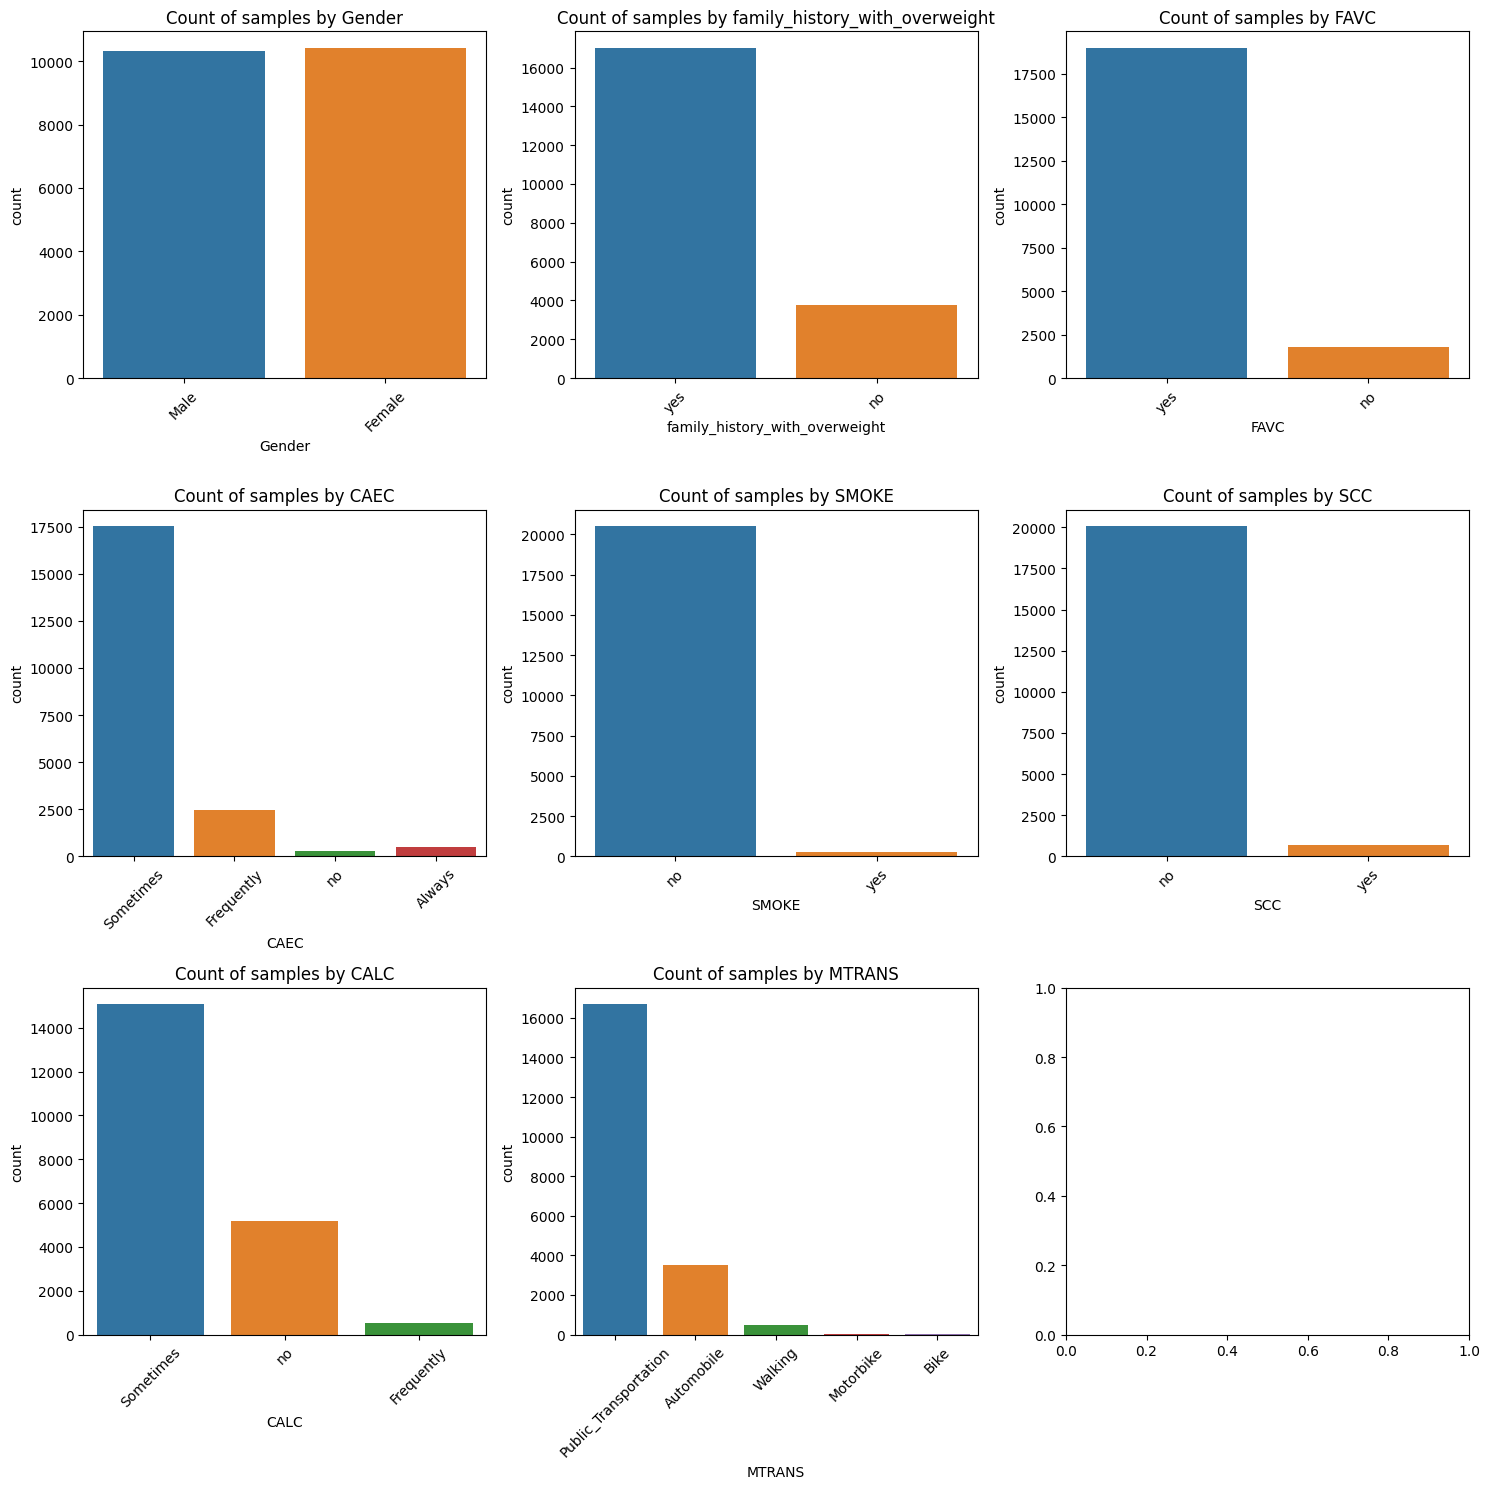

In [13]:
# Calculate the number of rows and columns for subplots
num_cols = 3  # Number of columns for subplots
num_rows = (len(categorical_features) - 1) // num_cols + 1  # Number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Exploring categorical features
for i, feature in enumerate(categorical_features):
    row = i // num_cols
    col = i % num_cols

    print(f"Unique values for {feature} in train data: {train[feature].unique()}")
    if feature == "NObeyesdad":
        continue
    print(f"Unique values for {feature} in test data: {test[feature].unique()}")

    # Countplot for visualization
    sns.countplot(x=feature, data=train, ax=axes[row, col])
    axes[row, col].set_title(f"Count of samples by {feature}")
    axes[row, col].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
# this code was taken from:  https://www.kaggle.com/code/mariushinsberger/xgboost-on-obesity-risk
all_df = pd.concat([train, test], keys=[0, 1], axis=0)
for feature in categorical_features:
    if feature == "MTRANS":
        df_onehot = pd.get_dummies(all_df['MTRANS'])
        all_df = pd.concat([all_df, df_onehot], axis=1)
        all_df.drop(columns=["MTRANS"], inplace=True)
    else:
        all_df[feature] = all_df[feature].map(feature_dict[feature])
    
train = all_df.xs(0).copy()
test = all_df.xs(1).copy()
target = target.map(obesity_dict)

In [15]:
train.head().T

,0,1,2,3,4
Gender,1,0,0,0,1
Age,24.443011,18.0,18.0,20.952737,31.641081
Height,1.699998,1.56,1.71146,1.71073,1.914186
Weight,81.66995,57.0,50.165754,131.274851,93.798055
family_history_with_overweight,1,1,1,1,1
FAVC,1,1,1,1,1
FCVC,2.0,2.0,1.880534,3.0,2.679664
NCP,2.983297,3.0,1.411685,3.0,1.971472
CAEC,1,2,1,1,1
SMOKE,0,0,0,0,0


# Model

# A Bit About XGBoost
* It is a part of ensemble learning: we combine multiple ML models and then aggregate the result 
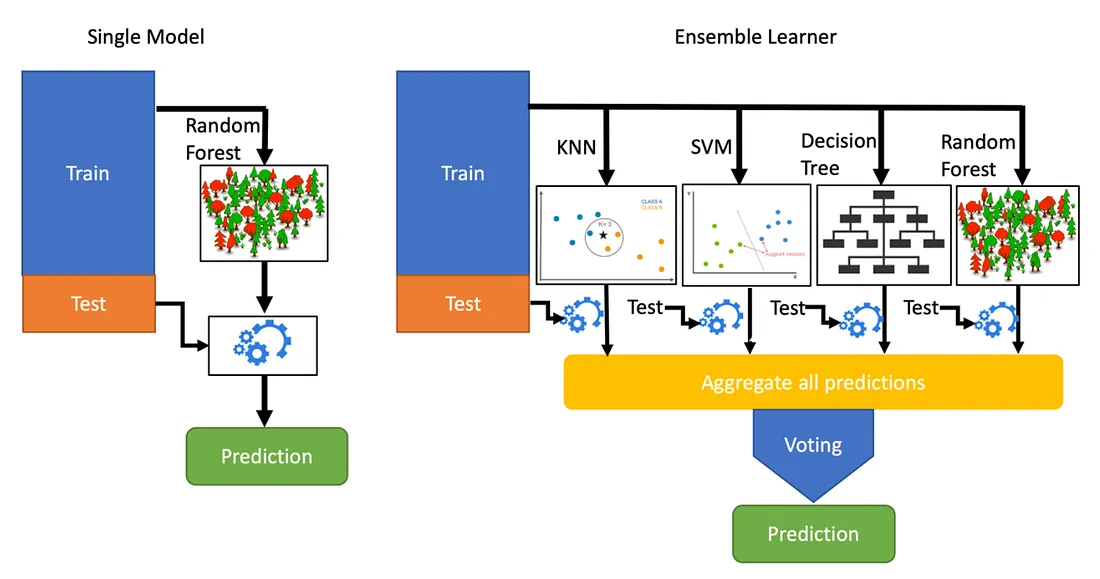

**Understanding the Parameters**
1. learning_rate: This parameter controls the step size at each iteration while moving toward a minimum of the loss function. It's analogous to the step size in gradient descent. A smaller learning rate requires more iterations but may lead to better convergence.
2. n_estimators: This parameter specifies the number of boosting rounds or trees to build. Each boosting round contributes an additional tree to the model. Increasing the number of estimators generally improves performance, but it also increases the computational cost.
3. max_depth: This parameter sets the maximum depth of a tree. Deeper trees can capture more complex patterns in the data, but they are more prone to overfitting. Limiting the maximum depth helps control overfitting.
4. min_child_weight: This parameter specifies the minimum sum of instance weight (hessian) needed in a child. It is used to control over-fitting. Higher values prevent the model from learning relationships which might be highly specific to the particular sample selected for a tree.
5. gamma: This parameter specifies the minimum loss reduction required to make a further partition on a leaf node of the tree. It acts as a regularization parameter. Higher values lead to fewer splits, thus making the algorithm more conservative.
6. colsample_bytree: This parameter specifies the fraction of features to be randomly sampled for each tree. It controls the randomness in feature selection. A value less than 1.0 results in stochastic gradient boosting.
7. subsample: This parameter specifies the fraction of observations to be randomly sampled for each tree. It controls the randomness of the training instances. Lower values make the algorithm more conservative and prevent overfitting.
8. objective: This parameter specifies the learning task and the corresponding objective function. In this case, 'multi:softprob' indicates a multi-class classification problem, and the objective function returns the predicted probability of each class.
9. nthread: This parameter specifies the number of parallel threads used for tree construction. A value of -1 means using all available threads.
10. random_state: This parameter sets the seed for random number generation, ensuring reproducibility of results.


In [16]:
X = train
y = target
X_test = test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
xgb_0 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=140,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    colsample_bytree=0.8,
    subsample=0.8,
    objective= 'multi:softprob',
    nthread=-1,
    random_state=42
)

Now obviously I want to know how to optimize these parameters, so let's take a closer look:
1. We will optimize the learning rate using grid search. The code below shows that the optimal learning rate is 0.1. By altering just the learning rate, I was able to get an accuracy of 0.9099 for the train dataset.


In [18]:
# Define the range of learning rates to search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_0, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best learning rate:", grid_search.best_params_['learning_rate'])

Best learning rate: 0.1


Now let's have a look at the number of estimators. I will be using a new technique to me - the grid search. Here is how ChatGPT-4 explained it to me:

> Alright, imagine you have a big box of different colored candies, and you want to find out which one tastes the best. But you're not sure which color is the tastiest, so you decide to ask your friends for their opinions.

> Grid search is a bit like asking your friends to try all the candies and tell you which one they like the most. Here's how it works:

> You make a list: First, you make a list of all the candies (or in our case, all the possible values for the parameter you want to find, like the number of trees in a forest).

> Your friends try the candies: Next, you give each friend a different candy to taste. Each friend tells you which candy they think tastes the best.

> You pick the favorite: Once all your friends have tried the candies and told you their favorite, you look at their answers and see which candy got the most votes. That candy is probably the tastiest!
> 
> In the same way, grid search tries out different values of a parameter for a machine learning model (like the number of trees in a forest). It tests these values by training the model with each one and seeing how well it performs.

And, to be honest, that made more sense than my maths lecture so let's go with it.

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': range(100, 1000, 100)  # Range of values for n_estimators to search
}

# Instantiate the XGBClassifier
xgb_0 = XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    colsample_bytree=0.8,
    subsample=0.8,
    objective='multi:softprob',
    nthread=-1,
    random_state=42
)

# Instantiate the GridSearchCV object with n_jobs=-1 for parallel processing
grid_search = GridSearchCV(estimator=xgb_0, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best number of estimators
best_n_estimators = grid_search.best_params_['n_estimators']

print("Best number of estimators:", best_n_estimators)

Best number of estimators: 200


As we can see we have now got 200 estimators as the best number, and with this, we boost our accuracy to 0.9116 from 0.9099 (see what I did there :)

In [20]:
xgb_0 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=200,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    colsample_bytree=0.8,
    subsample=0.8,
    objective= 'multi:softprob',
    nthread=-1,
    random_state=42
)

In [21]:
def fit_xgb_classifier(model, X_train, y_train, X_val, y_val, verbose=100):
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=verbose)
    
    acc_train = accuracy_score(model.predict(X_train),y_train)
    acc_val = accuracy_score(model.predict(X_val),y_val)
    print(f"train_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")
    
    results = model.evals_result()
    val_mlogloss = results["validation_1"]["mlogloss"]
    best_epopch = min(val_mlogloss)
    i_best_epoch = val_mlogloss.index(best_epopch)
    print(f"Best mlogloss: {best_epopch}\nBest epoch: {i_best_epoch}")
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    # plot m log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.plot(i_best_epoch, best_epopch, marker="o", color="green", label="Best")
    ax.legend()
    plt.ylabel('M Log Loss')
    plt.title('XGBoost M Log Loss')
    plt.show()

[0]	validation_0-mlogloss:1.72387	validation_1-mlogloss:1.72694
[100]	validation_0-mlogloss:0.20351	validation_1-mlogloss:0.27223
[199]	validation_0-mlogloss:0.13616	validation_1-mlogloss:0.26564
train_accuracy: 0.9584
test_accuracy: 0.9116
Best mlogloss: 0.26551369762438753
Best epoch: 194


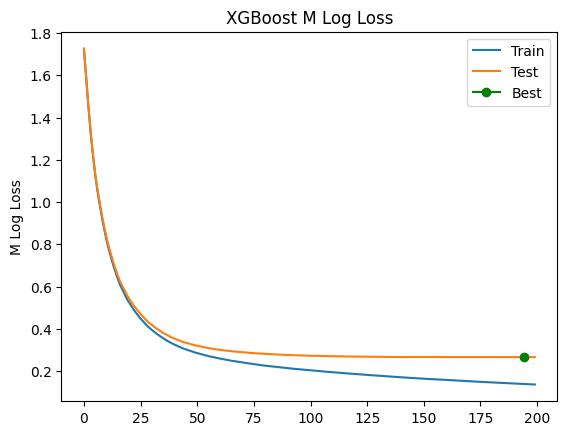

In [22]:
fit_xgb_classifier(xgb_0, X_train, y_train, X_val, y_val)

In [23]:
best = xgb_0
predictions = best.predict(X_test)
submission["NObeyesdad"] = predictions
submission["NObeyesdad"] = submission["NObeyesdad"].map(inverse_obesity_dict)
submission.head(20)

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
5,20763,Insufficient_Weight
6,20764,Insufficient_Weight
7,20765,Normal_Weight
8,20766,Overweight_Level_II
9,20767,Normal_Weight


In [24]:
submission.to_csv("submission.csv", index=False)